In [106]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)

# Adding Injury Data

In [116]:
# Reading in the csv

injuries = pd.read_csv('injuries.csv')
injuries.head()

,Date,Team,Acquired,Relinquised,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Pendergraph / Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


In [117]:
# Checking out the shape

injuries.shape

(9783, 5)

In [118]:
# Looking at the amount of null values

injuries['Relinquised'].isnull().sum()

1589

In [119]:
# Creating a column for injuries that contain the word "torn"

injuries['Tears'] = injuries['Notes'].str.contains('torn')

In [120]:
injuries.head()

,Date,Team,Acquired,Relinquised,Notes,Tears
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,False
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Acchilles tendon (out indefinitely),True
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,False
3,2010-10-08,Blazers,NaN,Jeff Pendergraph / Jeff Ayres,torn ACL in right knee (out indefinitely),True
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),False


In [121]:
# Creating separate dataframe for tears

tears = injuries.loc[injuries['Tears'] == True]

In [122]:
# Getting rid of unnecessary column/changing name of columns

tears.drop('Acquired', axis=1, inplace = True)
tears = tears.rename(columns={'Relinquised':'Name'})

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
# Dropping duplicate columns. There were a lot of duplicates because players would be listed as injured once for
# the injury, and again for their surgery. I broke the dataframe up into years because once a player tears something,
# they are generally out for the season with that injury.

tears2011 = tears[:28].drop_duplicates('Name')
tears2012 = tears[28:94].drop_duplicates('Name')
tears2013 = tears[94:149].drop_duplicates('Name')
tears2014 = tears[149:313].drop_duplicates('Name')
tears2015 = tears[313:343].drop_duplicates('Name')
tears2016 = tears[343:372].drop_duplicates('Name')
tears2017 = tears[372:406].drop_duplicates('Name')
tears2018 = tears[406:].drop_duplicates('Name')

# Added a year column

tears2011['Year'] = 2011
tears2012['Year'] = 2012
tears2013['Year'] = 2013
tears2014['Year'] = 2014
tears2015['Year'] = 2015
tears2016['Year'] = 2016
tears2017['Year'] = 2017
tears2018['Year'] = 2018

In [125]:
# Concatenated the tear year dataframes into one dataframe. Also replaced null values with a 0. If the value was null,
# that means that there was no injury.

to_concat = (tears2011, tears2012, tears2013, tears2014, tears2015, tears2016, tears2017, tears2018)
all_tears = pd.concat(to_concat)
all_tears = all_tears.fillna(0)

In [126]:
# Created specific columns for Achilles, ACL, and Meniscus tears

all_tears['Achilles'] = all_tears['Notes'].str.contains('Achilles')
all_tears['ACL'] = all_tears['Notes'].str.contains('ACL')
all_tears['Meniscus'] = all_tears['Notes'].str.contains('meniscus')

In [19]:
all_tears.head()

,Date,Team,Name,Notes,Tears,Year,Achilles,ACL,Meniscus
1,2010-10-06,Pistons,Jonas Jerebko,torn right Acchilles tendon (out indefinitely),True,2011,False,False,False
3,2010-10-08,Blazers,Jeff Pendergraph / Jeff Ayres,torn ACL in right knee (out indefinitely),True,2011,False,True,False
7,2010-10-09,Nuggets,Al Harrington,partially torn plantar fascia in left foot (ou...,True,2011,False,False,False
86,2010-11-23,Heat,Udonis Haslem,surgery on left foot to repair torn ligament (...,True,2011,False,False,False
161,2010-12-15,Bulls,Joakim Noah,torn ligament in right thumb (out indefinitely),True,2011,False,False,False


In [127]:
# There was a problem row that had the players name listed as '0'. The entry was for Russell Westbrook, but that injury
# was already listed so I deleted the row

all_tears = all_tears[all_tears.Name != 0]

In [128]:
# Changing the tear counts from strings to floats

all_tears['Tears'] = all_tears['Tears'].astype(float)
all_tears['Achilles'] = all_tears['Achilles'].astype(float)
all_tears['ACL'] = all_tears['ACL'].astype(float)
all_tears['Meniscus'] = all_tears['Meniscus'].astype(float)

In [129]:
# Created a column with the name and the year of each player to make joining with the main dataframe easier

all_tears["Join Name With Year"] = all_tears["Year"].map(str) + ' ' + all_tears["Name"]

In [130]:
# Reset index because it was out of order. Also dropped the columns titled "index" as a result of this
all_tears = all_tears.reset_index()
all_tears.drop('index', axis=1, inplace=True)

In [131]:
# Created more rows for each player in order to create cumulative sum columns

years = []

for i, row in all_tears.iterrows():
    year = int(all_tears['Join Name With Year'][i][:4])
    while year <= 2018:
        if not all_tears['Join Name With Year'][i] in years:
            new_row = [0, all_tears['Team'][i], all_tears['Name'][i], 'None', 0, year+1,
                                    0, 0, 0, (str(year+1) + all_tears['Join Name With Year'][i][4:])]
            if not new_row[-1] in all_tears.values:
                all_tears.loc[len(all_tears)] = new_row
                years.append((str(year+1) + all_tears['Join Name With Year'][i][4:]))
        year = year + 1

In [132]:
# Sorted the dataframe by name and year for cumulative sum purposes

all_tears = all_tears.sort_values(['Name', 'Year'])

In [133]:
# Created cumulative sum

all_tears['Meniscus Sum'] = all_tears.groupby('Name')['Meniscus'].cumsum()
all_tears['Achilles Sum'] = all_tears.groupby('Name')['Achilles'].cumsum()
all_tears['ACL Sum'] = all_tears.groupby('Name')['ACL'].cumsum()
all_tears['Tear Sum'] = all_tears.groupby('Name')['Tears'].cumsum()

In [135]:
# Created a Meniscus/Achilles/ACL sum column

all_tears['Meniscus/Achilles/ACL Sum'] = all_tears['Meniscus Sum'] + all_tears['Achilles Sum'] + all_tears['ACL Sum']

In [134]:
# Set the index in preparation for join with main dataframe

all_tears = all_tears.set_index('Join Name With Year')

# Reading In Free Agent Data

In [136]:
FA2008 = pd.read_csv('2008_Free_Agents.csv')
FA2009 = pd.read_csv('2009_Free_Agents.csv')
FA2010 = pd.read_csv('2010_Free_Agents.csv')
FA2011 = pd.read_csv('2011_Free_Agents.csv')
FA2012 = pd.read_csv('2012_Free_Agents.csv')
FA2013 = pd.read_csv('2013_Free_Agents.csv')
FA2014 = pd.read_csv('2014_Free_Agents.csv')
FA2015 = pd.read_csv('2015_Free_Agents.csv')
FA2016 = pd.read_csv('2016_Free_Agents.csv')
FA2017 = pd.read_csv('2017_Free_Agents.csv')
FA2018 = pd.read_csv('2018_Free_Agents.csv')
stats = pd.read_csv('../all_historical_stats.csv')

/Users/jordanarnold22/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (38,85,88,137,184,187,199,237,284,287,334,337,384,387,434,437,484,487,534,537,584,587,634,637,1291,1342,1393,1444,1495,1546,1597,1647) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [137]:
# Reseting index

stats = stats.set_index('Name')
stats.drop('Unnamed: 0', axis=1, inplace=True)

In [138]:
# Making sure there are no duplicate rows

stats = stats.drop_duplicates()

In [139]:
# Creating dataframes for each year's free agents

FA2018 = stats[(stats.index.isin(FA2018['Player']))]
FA2017 = stats[(stats.index.isin(FA2017['Player']))]
FA2016 = stats[(stats.index.isin(FA2016['Player']))]
FA2015 = stats[(stats.index.isin(FA2015['Player']))]
FA2014 = stats[(stats.index.isin(FA2014['Player']))]
FA2013 = stats[(stats.index.isin(FA2013['Player']))]
FA2012 = stats[(stats.index.isin(FA2012['Player']))]
FA2011 = stats[(stats.index.isin(FA2011['Player']))]
FA2010 = stats[(stats.index.isin(FA2010['Player']))]
FA2009 = stats[(stats.index.isin(FA2009['July']))]
FA2008 = stats[(stats.index.isin(FA2008['Player']))]

In [140]:
# Setting index to year + player

FA2018.index = '2018-19 ' + FA2018.index
FA2017.index = '2017-18 ' + FA2017.index
FA2016.index = '2016-17 ' + FA2016.index
FA2015.index = '2015-16 ' + FA2015.index
FA2014.index = '2014-15 ' + FA2014.index
FA2013.index = '2013-14 ' + FA2013.index
FA2012.index = '2012-13 ' + FA2012.index
FA2011.index = '2011-12 ' + FA2011.index
FA2010.index = '2010-11 ' + FA2010.index
FA2009.index = '2009-10 ' + FA2009.index
FA2008.index = '2008-09 ' + FA2008.index


In [141]:
# Ensuring that the players that I'm looking at played last year...and were paid to do so

FA2008 = FA2008[FA2008['2008-09 Salary'].notnull()]
FA2009 = FA2009[FA2009['2009-10 Salary'].notnull()]
FA2010 = FA2010[FA2010['2010-11 Salary'].notnull()]
FA2011 = FA2011[FA2011['2011-12 Salary'].notnull()]
FA2012 = FA2012[FA2012['2012-13 Salary'].notnull()]
FA2013 = FA2013[FA2013['2013-14 Salary'].notnull()]
FA2014 = FA2014[FA2014['2014-15 Salary'].notnull()]
FA2015 = FA2015[FA2015['2015-16 Salary'].notnull()]
FA2016 = FA2016[FA2016['2016-17 Salary'].notnull()]
FA2017 = FA2017[FA2017['2017-18 Salary'].notnull()]

In [142]:
# Double checking that the players that I'm looking at played last year...with a professional basketball team

FA2008 = FA2008[FA2008['2007-08 Team'].notnull()]
FA2009 = FA2009[FA2009['2008-09 Team'].notnull()]
FA2010 = FA2010[FA2010['2009-10 Team'].notnull()]
FA2011 = FA2011[FA2011['2010-11 Team'].notnull()]
FA2012 = FA2012[FA2012['2011-12 Team'].notnull()]
FA2013 = FA2013[FA2013['2012-13 Team'].notnull()]
FA2014 = FA2014[FA2014['2013-14 Team'].notnull()]
FA2015 = FA2015[FA2015['2014-15 Team'].notnull()]
FA2016 = FA2016[FA2016['2015-16 Team'].notnull()]
FA2017 = FA2017[FA2017['2016-17 Team'].notnull()]
FA2018 = FA2018[FA2018['2017-18 Team'].notnull()]

In [143]:
# Setting up lists of playoff teams, teams that made the Semifinals, teams that made the finals, and teams that were
# in the bottom 3 teams of each conference for every year

Playoff2018 = ['BOS', 'MIL', 'CLE', 'IND', 'PHI', 'MIA', 'TOR', 'WAS', 'HOU', 'MIN', 'SAS', 'GSW', 'OKC', 'POR', 'NOP', 'UTA']
Semi2018 = ['GSW', 'CLE', 'BOS', 'HOU']
Title2018 = ['GSW', 'CLE']
Bottom2018 = ['PHO', 'MEM', 'DAL', 'ATL', 'ORL', 'CHI']
Playoff2017 = ['BOS', 'CHI', 'CLE', 'IND', 'TOR', 'MIL', 'WAS', 'ATL', 'GSW', 'POR', 'HOU', 'OKC', 'UTA', 'LAC', 'SAS', 'MEM']
Semi2017 = ['GSW', 'CLE', 'BOS', 'SAS']
Title2017 = ['GSW', 'CLE']
Bottom2017 = ['MIN', 'LAL', 'PHO', 'ORL', 'PHI', 'BKN']
Playoff2016 = ['ATL', 'BOS', 'CLE', 'DET', 'MIA', 'CHO', 'TOR', 'IND', 'GSW', 'HOU', 'DAL', 'OKC', 'POR', 'LAC', 'SAS', 'MEM']
Semi2016 = ['CLE', 'TOR', 'GSW', 'OKC']
Title2016 = ['CLE', 'GSW']
Bottom2016 = ['NYK', 'BKN', 'PHI', 'MIN', 'PHO', 'LAL']
Playoff2015 = ['ATL', 'CHI', 'MIL', 'BRK', 'CLE', 'BOS', 'WAS', 'TOR', 'GSW', 'NOP', 'HOU', 'DAL', 'LAC', 'SAS', 'POR', 'LAC']
Semi2015 = ['CLE', 'GSW', 'ATL', 'HOU']
Title2015 = ['CLE', 'GSW']
Bottom2015 = ['NYK', 'PHI', 'ORL', 'MIN', 'SAC', 'LAL']
Playoff2014 = ['BRK', 'TOR', 'IND', 'ATL', 'MIA', 'CHA', 'WAS', 'CHI', 'GSW', 'LAC', 'OKC', 'MEM', 'POR', 'HOU', 'SAS', 'DAL']
Semi2014 = ['SAS', 'MIA', 'OKC', 'IND']
Title2014 = ['CLE', 'SAS']
Bottom2014 = ['MIL', 'PHI', 'ORL', 'UTA', 'SAC', 'LAL']
Playoff2013 = ['CHI', 'BRK', 'IND', 'ATL', 'MIA', 'MIL', 'NYK', 'BOS', 'GSW', 'DEN', 'MEM', 'LAC', 'OKC', 'HOU', 'SAS', 'LAL']
Semi2013 = ['MIA', 'IND', 'SAS', 'MEM']
Title2013 = ['MIA', 'SAS']
Bottom2013 = ['CHA', 'CLE', 'ORL', 'SAC', 'PHO', 'NOH']
Playoff2012 = ['BOS', 'IND', 'ATL', 'ORL', 'MIA', 'NYK', 'PHI', 'CHI', 'LAC', 'LAL', 'MEM', 'DEN', 'OKC', 'SAS', 'DAL', 'UTA']
Semi2012 = ['MIA', 'OKC', 'BOS', 'SAS']
Title2012 = ['MIA', 'OKC']
Bottom2012 = ['CHA', 'WAS', 'CLE', 'NOH', 'GSW', 'SAC']
Playoff2011 = ['ATL', 'ORL', 'BOS', 'NYK', 'CHI', 'IND', 'PHI', 'MIA', 'DAL', 'POR', 'LAL', 'MEM', 'SAS', 'OKC', 'DEN', 'NOH']
Semi2011 = ['MIA', 'CHI', 'DAL', 'OKC']
Title2011 = ['MIA', 'DAL']
Bottom2011 = ['CLE', 'TOR', 'WAS', 'MIN', 'SAC', 'LAC']
Playoff2010 = ['ATL', 'MIL', 'BOS', 'MIA', 'CLE', 'CHI', 'ORL', 'CHA', 'LAL', 'OKC', 'POR', 'SAS', 'DAL', 'DEN', 'UTA', 'PHO']
Semi2010 = ['BOS', 'LAL', 'PHO', 'ORL']
Title2010 = ['BOS', 'LAL']
Bottom2010 = ['NJN', 'DET', 'PHI', 'WAS']
Playoff2009 = ['ATL', 'BOS', 'MIA', 'CHI', 'CLE', 'DET', 'ORL', 'PHI', 'DAL', 'SAS', 'NOH', 'DEN', 'HOU', 'POR', 'LAL', 'UTA']
Semi2009 = ['ORL', 'LAL', 'CLE', 'DEN']
Title2009 = ['ORL', 'LAL']
Bottom2009 = ['WAS', 'NYK', 'TOR', 'LAC', 'SAC', 'OKC']
Playoff2008 = ['BOS', 'ATL', 'CLE', 'WAS', 'DET', 'PHI', 'ORL', 'TOR', 'LAL', 'DEN', 'NOH', 'DAL', 'SAS', 'PHO', 'UTA', 'HOU']
Semi2008 = ['LAL', 'BOS', 'DET', 'SAS']
Title2008 = ['LAL', 'BOS']
Bottom2008 = ['MIA', 'MIL', 'NYK', 'MIN', 'MEM', 'SEA']




# Creating Historical Dataframes For Each Year Of Free Agency

In [144]:
# Creating function to feed previous year data to each free agent dataframe

def create_df(hist, FA_year, stat_year, stat_2_years_ago, target_salary_year, salary_cap, luxury_tax, playoff, semi, title, bottom):

    hist['Previous Year Games Played'] = FA_year[stat_year + ' Games Played'].values
    hist['Previous Year Games Started'] = FA_year[stat_year + ' Games Started'].values
    hist['Previous Year Minutes Per Game'] = FA_year[stat_year + ' Minutes Per Game'].values
    hist['Previous Year Field Goals Per Game'] = FA_year[stat_year + ' Field Goals Per Game'].values
    hist['Previous Year Field Goal Attempts Per Game'] = FA_year[stat_year + ' Field Goal Attempts Per Game'].values
    hist['Previous Year Field Goal Percentage'] = FA_year[stat_year + ' Field Goal Percentage'].values
    hist['Previous Year 3 Point Field Goals Per Game'] = FA_year[stat_year + ' 3 Point Field Goals Per Game'].values
    hist['Previous Year 3 Point Field Goal Attempts Per Game'] = FA_year[stat_year + ' 3 Point Field Goal Attempts Per Game'].values
    hist['Previous Year 3 Point Field Goal Percentage'] = FA_year[stat_year + ' 3 Point Field Goal Percentage'].values
    hist['Previous Year 2 Point Field Goals Per Game'] = FA_year[stat_year + ' 3 Point Field Goals Per Game'].values
    hist['Previous Year 2 Point Field Goal Attempts Per Game'] = FA_year[stat_year + ' 3 Point Field Goal Attempts Per Game'].values
    hist['Previous Year 2 Point Field Goal Percentage'] = FA_year[stat_year + ' 3 Point Field Goal Percentage'].values
    hist['Previous Year Effective Field Goal Percentage'] = FA_year[stat_year + ' Effective Field Goal Percentage'].values
    hist['Previous Year Free Throw Makes Per Game'] = FA_year[stat_year + ' Free Throw Makes Per Game'].values
    hist['Previous Year Free Throw Attempts Per Game'] = FA_year[stat_year + ' Free Throw Attempts Per Game'].values
    hist['Previous Year Free Throw Percentage'] = FA_year[stat_year + ' Free Throw Percentage'].values
    hist['Previous Year Offensive Rebounds Per Game'] = FA_year[stat_year + ' Offensive Rebounds Per Game'].values
    hist['Previous Year Defensive Rebounds Per Game'] = FA_year[stat_year + ' Defensive Rebounds Per Game'].values
    hist['Previous Year Total Rebounds Per Game'] = FA_year[stat_year + ' Total Rebounds Per Game'].values
    hist['Previous Year Assists Per Game'] = FA_year[stat_year + ' Assists Per Game'].values
    hist['Previous Year Steals Per Game'] = FA_year[stat_year + ' Steals Per Game'].values
    hist['Previous Year Blocks Per Game'] = FA_year[stat_year + ' Blocks Per Game'].values
    hist['Previous Year Turnovers Per Game'] = FA_year[stat_year + ' Turnovers Per Game'].values
    hist['Previous Year Personal Fouls Per Game'] = FA_year[stat_year + ' Personal Fouls Per Game'].values
    hist['Previous Year Points Per Game'] = FA_year[stat_year + ' Points Per Game'].values
    hist['Previous Year Team'] = FA_year[stat_year + ' Team'].values
    playoff_teams = []
    for i in hist['Previous Year Team']:
        playoff_teams.append(int(i in eval('Playoff' + playoff)))
    hist['Previous Year Playoff Team'] = playoff_teams
    semifinal_teams = []
    for i in hist['Previous Year Team']:
        semifinal_teams.append(int(i in eval('Semi' + semi)))
    hist['Previous Year Semifinal Team'] = semifinal_teams
    final_teams = []
    for i in hist['Previous Year Team']:
        final_teams.append(int(i in eval('Title' + title)))
    hist['Previous Year Final Team'] = final_teams
    bottom_6_teams = []
    for i in hist['Previous Year Team']:
        bottom_6_teams.append(int(i in eval('Bottom' + bottom)))
    hist['Previous Year Bottom 6 Team'] = bottom_6_teams
    
    hist['Previous Year Total Minutes Played'] = FA_year[stat_year + ' Total Minutes Played'].values
    hist['Previous Year Player Efficiency Rating'] = FA_year[stat_year + ' Player Efficiency Rating'].values
    hist['Previous Year True Shooting Percentage'] = FA_year[stat_year + ' True Shooting Percentage'].values
    hist['Previous Year 3 Point Attempt Rate'] = FA_year[stat_year + ' 3 Point Attempt Rate'].values
    hist['Previous Year Free Throw Attempt Rate'] = FA_year[stat_year + ' Free Throw Attempt Rate'].values
    hist['Previous Year Offensive Rebound Percentage'] = FA_year[stat_year + ' Offensive Rebound Percentage'].values
    hist['Previous Year Defensive Rebound Percentage'] = FA_year[stat_year + ' Defensive Rebound Percentage'].values
    hist['Previous Year Total Rebound Percentage'] = FA_year[stat_year + ' Total Rebound Percentage'].values
    hist['Previous Year Assist Percentage'] = FA_year[stat_year + ' Assist Percentage'].values
    hist['Previous Year Steal Percentage'] = FA_year[stat_year + ' Steal Percentage'].values
    hist['Previous Year Block Percentage'] = FA_year[stat_year + ' Block Percentage'].values
    hist['Previous Year Turnover Percentage'] = FA_year[stat_year + ' Turnover Percentage'].values
    hist['Previous Year Usage Percentage'] = FA_year[stat_year + ' Usage Percentage'].values
    hist['Previous Year Offensive Win Shares'] = FA_year[stat_year + ' Offensive Win Shares'].values
    hist['Previous Year Defensive Win Shares'] = FA_year[stat_year + ' Defensive Win Shares'].values
    hist['Previous Year Win Shares'] = FA_year[stat_year + ' Win Shares'].values
    hist['Previous Year Win Shares Per 48 Minutes'] = FA_year[stat_year + ' Win Shares Per 48 Minutes'].values
    hist['Previous Year Offensive Box Plus/Minus'] = FA_year[stat_year + ' Offensive Box Plus/Minus'].values
    hist['Previous Year Defensive Box Plus/Minus'] = FA_year[stat_year + ' Defensive Box Plus/Minus'].values
    hist['Previous Year Box Plus/Minus'] = FA_year[stat_year + ' Box Plus/Minus'].values
    hist['Previous Year Value Over Replacement Player'] = FA_year[stat_year + ' Value Over Replacement Player'].values
    hist['Previous Year Salary'] = FA_year[stat_year + ' Salary'].values


    hist['Age'] = FA_year[stat_year + ' Age'].values
    hist['Years In League'] = FA_year[stat_year + ' Years In League'].values
    hist['Salary Cap'] = salary_cap
    hist['Luxury Tax Line'] = luxury_tax
    hist['Position'] = FA_year['Position'].values
    hist['Previous Year Team With Year'] = stat_year + ' ' + FA_year[stat_year + ' Team'].values
    hist['Previous Year Total Team Payroll'] = FA_year[stat_year + ' Total Team Payroll'].values
    sums = hist.groupby('Previous Year Team With Year')['Previous Year Salary'].sum()
    sum_list = []
    for i in hist['Previous Year Team With Year'].values:
        for j in sums.keys():
            if i == j:
                sum_list.append(sums[j])
                
    hist['Salary Sums'] = sum_list
    hist['Team Cap Space'] = hist['Previous Year Total Team Payroll'] - hist['Salary Sums']

    hist['Total NBA Cap Space'] = hist['Team Cap Space'].sum()

    hist['Target Salary'] = FA_year[target_salary_year + ' Salary'].values

    hist['Target Salary Percentage Cap'] = hist['Target Salary'] / hist['Salary Cap']
    hist['Target Salary Percentage Luxury'] = hist['Target Salary'] / hist['Luxury Tax Line']

2018 Available Space: 397162373

In [145]:
# Creating historical dataframes for each year of free agents

hist1 = pd.DataFrame(FA2017.index)
hist2 = pd.DataFrame(FA2016.index)
hist3 = pd.DataFrame(FA2015.index)
hist4 = pd.DataFrame(FA2014.index)
hist5 = pd.DataFrame(FA2013.index)
hist6 = pd.DataFrame(FA2012.index)
hist7 = pd.DataFrame(FA2011.index)
hist8 = pd.DataFrame(FA2010.index)
hist9 = pd.DataFrame(FA2009.index)
hist10 = pd.DataFrame(FA2008.index)

target_hist = pd.DataFrame(FA2018.index)

In [146]:
# Running each year of free agents through the above function

create_df(hist1, FA2017, '2016-17', '2015-16', '2017-18', 99093000, 119266000, '2017', '2017', '2017', '2017') 
create_df(hist2, FA2016, '2015-16', '2014-15', '2016-17', 94143000, 113287000, '2016', '2016', '2016', '2016') 
create_df(hist3, FA2015, '2014-15', '2013-14', '2015-16', 70000000, 84740000, '2015', '2015', '2015', '2015') 
create_df(hist4, FA2014, '2013-14', '2012-13', '2014-15', 63065000, 76829000, '2014', '2014', '2014', '2014') 
create_df(hist5, FA2013, '2012-13', '2011-12', '2013-14', 58679000, 71748000, '2013', '2013', '2013', '2013') 
create_df(hist6, FA2012, '2011-12', '2010-11', '2012-13', 58044000, 70307000, '2012', '2012', '2012', '2012') 
create_df(hist7, FA2011, '2010-11', '2009-10', '2011-12', 58044000, 70307000, '2011', '2011', '2011', '2011') 
create_df(hist8, FA2010, '2009-10', '2008-09', '2010-11', 58044000, 70307000, '2010', '2010', '2010', '2010') 
create_df(hist9, FA2009, '2008-09', '2007-08', '2009-10', 57700000, 69920000, '2009', '2009', '2009', '2009') 

create_df(target_hist, FA2018, '2017-18', '2016-17', '2018-19', 101869000, 123733000, '2018', '2018', '2018', '2018')

# Functions To Calculate Minimum and Maximum Salaries

In [147]:
# Setting up a function that calculates the minimum salary that a player can receive based on what year it is and how
# long the player has been in the league

def minimum(years, target_salary_year):
    if target_salary_year == '2018-19':
        if years == 1.0:
            return 838464
        elif years == 2.0:
            return 1349383
        elif years == 3.0:
            return 1512601
        elif years == 4.0:
            return 1567007
        elif years == 5.0:
            return 1621415
        elif years == 6.0:
            return 1757429
        elif years == 7.0:
            return 1893447
        elif years == 8.0:
            return 2029463
        elif years == 9.0:
            return 2165481
        elif years == 10.0:
            return 2176260
        else:
            return 2393887
    elif target_salary_year == '2017-18':
        if years == 1.0:
            return 815615
        elif years == 2.0:
            return 1312611
        elif years == 3.0:
            return 1471382
        elif years == 4.0:
            return 1524305
        elif years == 5.0:
            return 1577230
        elif years == 6.0:
            return 1709538
        elif years == 7.0:
            return 1841849
        elif years == 8.0:
            return 1974159
        elif years == 9.0:
            return 2106470
        elif years == 10.0:
            return 2116955
        elif years >= 11.0:
            return 2328652
        else:
            return 0
    elif target_salary_year == '2016-17':
        if years == 1.0:
            return 543471
        elif years == 2.0:
            return 874636
        elif years == 3.0:
            return 980431
        elif years == 4.0:
            return 1015696
        elif years == 5.0:
            return 1050961
        elif years == 6.0:
            return 1139123
        elif years == 7.0:
            return 1227286
        elif years == 8.0:
            return 1315448
        elif years == 9.0:
            return 1403611
        elif years == 10.0:
            return 1410598
        elif years >= 11.0:
            return 1551659
        else:
            return 0
    elif target_salary_year == '2015-16':
        if years == 1.0:
            return 525093
        elif years == 2.0:
            return 845059
        elif years == 3.0:
            return 947276
        elif years == 4.0:
            return 981348
        elif years == 5.0:
            return 1015421
        elif years == 6.0:
            return 1100602
        elif years == 7.0:
            return 1185784
        elif years == 8.0:
            return 1270964
        elif years == 9.0:
            return 1356146
        elif years == 10.0:
            return 1362897
        elif years >= 11.0:
            return 1499187
        else:
            return 0
    elif target_salary_year == '2014-15':
        if years == 1.0:
            return 507336
        elif years == 2.0:
            return 816482
        elif years == 3.0:
            return 915243
        elif years == 4.0:
            return 948163
        elif years == 5.0:
            return 981084
        elif years == 6.0:
            return 1063384
        elif years == 7.0:
            return 1145685
        elif years == 8.0:
            return 1227985
        elif years == 9.0:
            return 1310286
        elif years == 10.0:
            return 1316809
        elif years >= 11.0:
            return 1448490
        else:
            return 0
    elif target_salary_year == '2013-14':
        if years == 1.0:
            return 490180   
        elif years == 2.0:
            return 788872
        elif years == 3.0:
            return 884293
        elif years == 4.0:
            return 916099
        elif years == 5.0:
            return 947907
        elif years == 6.0:
            return 1027424
        elif years == 7.0:
            return 1106942
        elif years == 8.0:
            return 1186459
        elif years == 9.0:
            return 1265977
        elif years == 10.0:
            return 1272279
        elif years >= 11.0:
            return 1399507
        else:
            return 0
    elif target_salary_year == '2012-13':
        if years == 1.0:
            return 473604   
        elif years == 2.0:
            return 762195
        elif years == 3.0:
            return 854389
        elif years == 4.0:
            return 885120
        elif years == 5.0:
            return 915852
        elif years == 6.0:
            return 992680
        elif years == 7.0:
            return 1069509
        elif years == 8.0:
            return 1146337
        elif years == 9.0:
            return 1223166
        elif years == 10.0:
            return 1229255
        elif years >= 11.0:
            return 1352181
        else:
            return 0
    elif target_salary_year == '2011-12':
        if years == 1.0:
            return 473604   
        elif years == 2.0:
            return 762195
        elif years == 3.0:
            return 854389
        elif years == 4.0:
            return 885120
        elif years == 5.0:
            return 915852
        elif years == 6.0:
            return 992680
        elif years == 7.0:
            return 1069509
        elif years == 8.0:
            return 1146337
        elif years == 9.0:
            return 1223166
        elif years == 10.0:
            return 1229255
        elif years >= 11.0:
            return 1352181
        else:
            return 0
    elif target_salary_year == '2010-11':
        if years == 1.0:
            return 473604  
        elif years == 2.0:
            return 762195
        elif years == 3.0:
            return 854389
        elif years == 4.0:
            return 885120
        elif years == 5.0:
            return 915852
        elif years == 6.0:
            return 992680
        elif years == 7.0:
            return 1069509
        elif years == 8.0:
            return 1146337
        elif years == 9.0:
            return 1223166
        elif years == 10.0:
            return 1229255
        elif years >= 11.0:
            return 1352181
        else:
            return 0
    elif target_salary_year == '2009-10':
        if years == 1.0:
            return 457588  
        elif years == 2.0:
            return 736420
        elif years == 3.0:
            return 825497
        elif years == 4.0:
            return 855189
        elif years == 5.0:
            return 884881
        elif years == 6.0:
            return 959111
        elif years == 7.0:
            return 1033342
        elif years == 8.0:
            return 1107572
        elif years == 9.0:
            return 1181803
        elif years == 10.0:
            return 1187686
        elif years >= 11.0:
            return 1306455
        else:
            return 0

In [148]:
# Setting up a function that calculates the maximum salary that a player can receive based on what year it is and how
# long the player has been in the league

def maximum(years, target_salary_year):
    if target_salary_year == '2018-19':
        if years >= 1 and years < 7:
            return 25467250
        elif years >= 7 and years < 11:
            return 30560700
        else:
            return 35654150
    if target_salary_year == '2017-18':
        if years >= 1 and years < 7:
            return 24773250
        elif years >= 7 and years < 11:
            return 29727900
        else:
            return 34682550
    if target_salary_year == '2016-17':
        if years >= 1 and years < 7:
            return 22116750
        elif years >= 7 and years < 11:
            return 26540100
        else:
            return 30963450
    if target_salary_year == '2015-16':
        if years >= 1 and years < 7:
            return 16407500
        elif years >= 7 and years < 11:
            return 19689000
        else:
            return 22970500
    if target_salary_year == '2014-15':
        if years >= 1 and years < 7:
            return 14746000
        elif years >= 7 and years < 11:
            return 17695200
        else:
            return 20644400
    if target_salary_year == '2013-14':
        if years >= 1 and years < 7:
            return 13701250
        elif years >= 7 and years < 11:
            return 16441500
        else:
            return 19181750
    if target_salary_year == '2012-13':
        if years >= 1 and years < 7:
            return 13668750
        elif years >= 7 and years < 11:
            return 16402500
        else:
            return 19136250
    if target_salary_year == '2011-12':
        if years >= 1 and years < 7:
            return 12922194
        elif years >= 7 and years < 11:
            return 15506632
        else:
            return 18091071
    if target_salary_year == '2010-11':
        if years >= 1 and years < 7:
            return 13603750
        elif years >= 7 and years < 11:
            return 16324500
        else:
            return 19045250
    if target_salary_year == '2009-10':
        if years >= 1 and years < 7:
            return 13520500
        elif years >= 7 and years < 11:
            return 16224600
        else:
            return 18928700

In [149]:
# Setting up blank lists to calculate minimums and maximums

Min2018 = []
Min2017 = []
Min2016 = []
Min2015 = []
Min2014 = []
Min2013 = []
Min2012 = []
Min2011 = []
Min2010 = []
Min2009 = []
Min2008 = []

Max2018 = []
Max2017 = []
Max2016 = []
Max2015 = []
Max2014 = []
Max2013 = []
Max2012 = []
Max2011 = []
Max2010 = []
Max2009 = []
Max2008 = []

In [44]:
# Creating a function that appends the minimum salary for each player to the dataframe

def append_minimum(df, list, year):
    for i in df['Years In League']:
        list.append(minimum(i, year))
    df['Minimum Salary'] = list
    
append_minimum(hist1, Min2017, '2017-18')
append_minimum(hist2, Min2016, '2016-17')
append_minimum(hist3, Min2015, '2015-16')
append_minimum(hist4, Min2014, '2014-15')
append_minimum(hist5, Min2013, '2013-14')
append_minimum(hist6, Min2012, '2012-13')
append_minimum(hist7, Min2011, '2011-12')
append_minimum(hist8, Min2010, '2010-11')
append_minimum(hist9, Min2009, '2009-10')

append_minimum(target_hist, Min2018, '2018-19')

In [150]:
# Creating a function that appends the maximum salary for each player to the dataframe

def append_maximum(df, list, year):
    for i in df['Years In League']:
        list.append(maximum(i, year))
    df['Maximum Salary'] = list

append_maximum(hist1, Max2017, '2017-18')
append_maximum(hist2, Max2016, '2016-17')
append_maximum(hist3, Max2015, '2015-16')
append_maximum(hist4, Max2014, '2014-15')
append_maximum(hist5, Max2013, '2013-14')
append_maximum(hist6, Max2012, '2012-13')
append_maximum(hist7, Max2011, '2011-12')
append_maximum(hist8, Max2010, '2010-11')
append_maximum(hist9, Max2009, '2009-10')

append_maximum(target_hist, Max2018, '2018-19')

# Concatenating Dataframes

In [151]:
to_concat = [hist1, hist2, hist3, hist4, hist5, hist6, hist7, hist8, hist9]
result = pd.concat(to_concat)

In [152]:
# Making sure there are no duplicate rows

result = result.drop_duplicates()
target_hist = target_hist.drop_duplicates()

In [153]:
# Renaming column

result = result.rename(columns={0: 'Name With Year'})
target_hist = target_hist.rename(columns={0: 'Name With Year'})

In [154]:
# Creating name and year columns

result['Name'] = [i[8:] for i in result['Name With Year']]
result['Year'] = [i[:2] + i[5:7] for i in result['Name With Year']]

target_hist['Name'] = [i[8:] for i in target_hist['Name With Year']]
target_hist['Year'] = [i[:2] + i[5:7] for i in target_hist['Name With Year']]

In [155]:
# Reseting index

result = result.reset_index()
target_hist = target_hist.reset_index()

In [156]:
# Editing the 'Name With Year' column to change the format from "2017-18 Name"  to "2018 Name"

for i in result['Name With Year']:
    i = i[:2] + i[5:7] + i[7:]
    
for i in target_hist['Name With Year']:
    i = i[:2] + i[5:7] + i[7:]

In [157]:
# Creating a 'Join Name With Year' column for the join with the injury data

result['Join Name With Year'] = result['Year'] + ' ' + result['Name']

target_hist['Join Name With Year'] = target_hist['Year'] + ' ' + target_hist['Name']

In [158]:
# Double checking again for duplicates

target_hist = target_hist.drop_duplicates()

In [159]:
# Setting up indices for the join

result = result.set_index('Join Name With Year')
target_hist = target_hist.set_index('Join Name With Year')

In [160]:
# Joining the main dataframe with the injury dataframe

result = result.join(all_tears, lsuffix='.x')
target_hist = target_hist.join(all_tears, lsuffix='.x')

In [161]:
# Saving as csv

result.to_csv('new_historical_df.csv')
target_hist.to_csv('2018_Free_Agents_For_Prediction.csv')

# Correlation Scatterplots

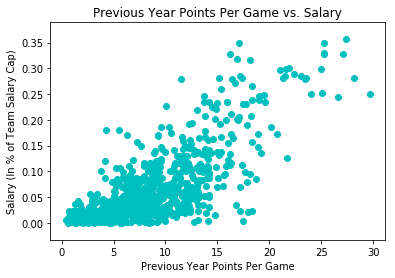

In [76]:
plt.xlabel('Previous Year Points Per Game')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Points Per Game vs. Salary')
plt.scatter(result['Previous Year Points Per Game'], result['Target Salary Percentage Cap'], c='c');

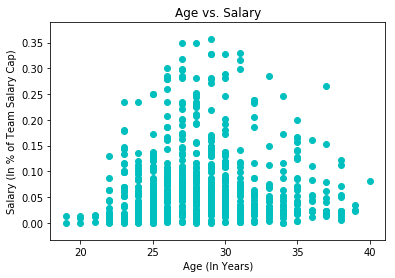

In [77]:
plt.xlabel('Age (In Years)')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Age vs. Salary')
plt.scatter(result['Age'], result['Target Salary Percentage Cap'], c='c');

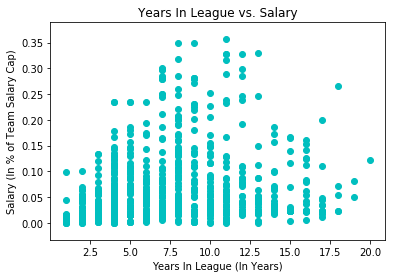

In [162]:
plt.xlabel('Years In League (In Years)')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Years In League vs. Salary')
plt.scatter(result['Years In League'], result['Target Salary Percentage Cap'], c='c');

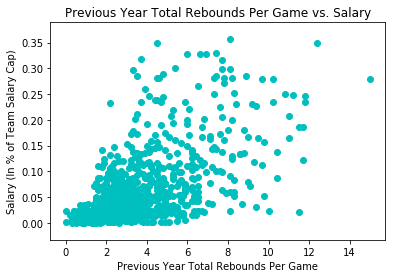

In [82]:
plt.xlabel('Previous Year Total Rebounds Per Game')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Total Rebounds Per Game vs. Salary')
plt.scatter(result['Previous Year Total Rebounds Per Game'], result['Target Salary Percentage Cap'], c='c');

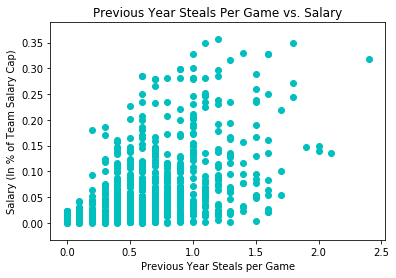

In [163]:
plt.xlabel('Previous Year Steals per Game')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Steals Per Game vs. Salary')
plt.scatter(result['Previous Year Steals Per Game'], result['Target Salary Percentage Cap'], c='c');

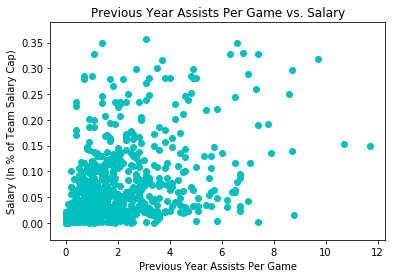

In [165]:
plt.xlabel('Previous Year Assists Per Game')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Assists Per Game vs. Salary')
plt.scatter(result['Previous Year Assists Per Game'], result['Target Salary Percentage Cap'], c='c')

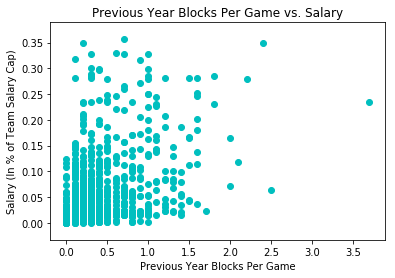

In [166]:
plt.xlabel('Previous Year Blocks Per Game')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Blocks Per Game vs. Salary')
plt.scatter(result['Previous Year Blocks Per Game'], result['Target Salary Percentage Cap'], c='c');

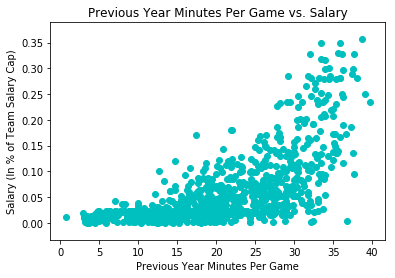

In [84]:
plt.xlabel('Previous Year Minutes Per Game')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Minutes Per Game vs. Salary')
plt.scatter(result['Previous Year Minutes Per Game'], result['Target Salary Percentage Cap'], c='c');

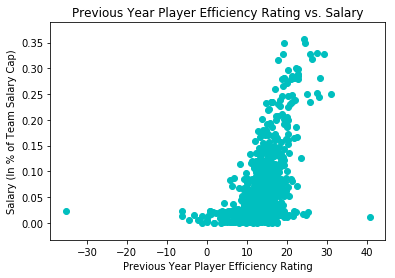

In [95]:
plt.xlabel('Previous Year Player Efficiency Rating')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Player Efficiency Rating vs. Salary')
plt.scatter(result['Previous Year Player Efficiency Rating'], result['Target Salary Percentage Cap'], c='c');

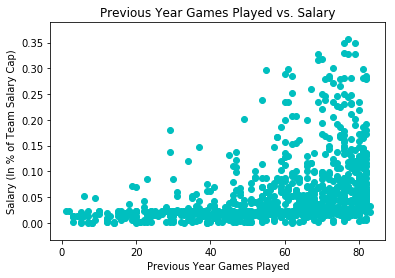

In [83]:
plt.xlabel('Previous Year Games Played')
plt.ylabel('Salary (In % of Team Salary Cap)')
plt.title('Previous Year Games Played vs. Salary')
plt.scatter(result['Previous Year Games Played'], result['Target Salary Percentage Cap'], c='c');